# SENATIONALISM CLASSIFIER

Sensationalism in a text is more about the style of writing rather than the content. Here events are worded in such a way to excite the participant. The style of news report encourages biased impressions of events rather than neutrality and may cause a manipulation to the trust of the story.

Hypothesis:
1. Sensationalism is more about criticising a one subject. 
2. It is more about personal opinion rather than factual information
3. Content is highlighted using punctuations and capital letters. Same content is written in more dramatical ways.

Why this classification is required?

Sensationalism in news articles is more about spreading a biased propoganda which may be true or not, rather than giving details about a particular event being discussed in the article. Therefore classifying a news as objective or not tells about the credibility of the article.

Dataset: 8000 sensational news article, 8000 objective news articles

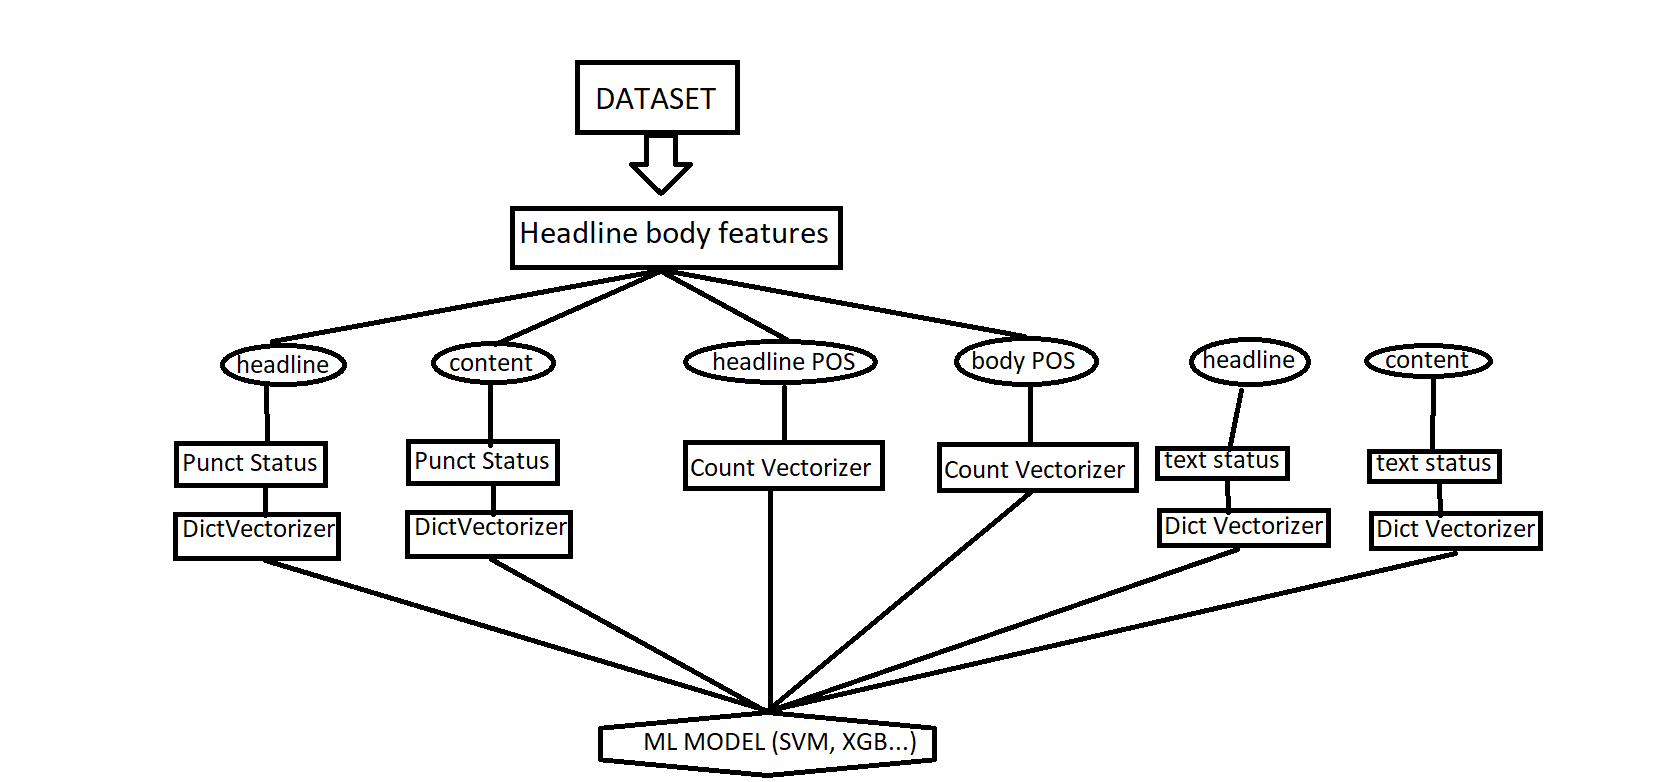

In [1]:
import pickle
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
#TransformerMixin provides automatic fit transform methods
#BaseEstimator provides set params, get params
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from collections import defaultdict
import string
import sys 
from pattern.db  import Datasheet
from pattern.db  import pd
import nltk
from random import shuffle
from pattern.en import sentiment
from pattern.en.wordlist import PROFANITY

In [2]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        
        return data_dict[self.key]

default dicts can handle missing values and has less complexity compared to normal dict

In [3]:
#HYPOTHESIS: Sensational news contains more Punctuations compared to objective news (eg !,?......)
class Punct_Stats(BaseEstimator, TransformerMixin):
    """Extract punctuation features from each document"""

    def fit(self, x, y=None):
        return self

    def transform(self, text_fields):
        punct_stats = []
        punctuations = list(string.punctuation)
        for field in text_fields:
            if field == None:
                field = " "
            puncts = defaultdict(int)
            for ch in field:
                if ch in punctuations:
                    puncts[ch]+=1
            punct_stats.append(puncts)
        return punct_stats

Pattern Sentiment-> polarity, subjectivity
1. Polarity (-1,1) -> based on positive and negative adjectives. A list of adjectives is already stored in their dataset with positve and negative rankings for a given adjective
2. Subjectivity (0,1) -> quantifies the amount of personal opinion and factual information contained in the text. "
higher scores points towards personal opinion
- Breaks up sentences into POS to identify noun, adjective ...etc
- Contains database with ranking of +ve nd -ve adjectives/adverbs
- each adjective is assigned a sentiment and thereafter average is used.

In [4]:
class Text_Stats(BaseEstimator, TransformerMixin):
    """Extract text statistics from each document"""

    def fit(self, x, y=None):
        return self

    def transform(self, text_fields):
        stats = []
       
        # abbreviations are used for not to be count in the capital letters features
        abvs = ['RBI','BCCI','CM','BJP','BSP','ICU','PPE','CNN', 'FBI', 'ABC', 'MSNBC', 'GOP', 'U.S.', 'US', 'ISIS', 'DNC', 'TV', 'CIA', 'I', 'AP', 'PM', 'AM', 'EU', 'USA', 'UK', 'UN', 'CEO', 'NASA', 'LGBT', 'LGBTQ', 'NAFTA', 'ACLU']
        for field in text_fields:
            field_stats = {}
            tok_text = nltk.word_tokenize(field)
            try:
                num_upper = float(len([w for w in tok_text if w.isupper() and w not in abvs]))/len(tok_text)
            except:
                num_upper = 0
     
            try:
                sent_lengths = [len(nltk.word_tokenize(s)) for s in nltk.sent_tokenize(field)]
                av_sent_len = float(sum(sent_lengths))/len(sent_lengths)
            except:
                av_sent_len = 0
            try:
                num_prof = float(len([w for w in tok_text if w.lower() in PROFANITY]))/len(tok_text)
            except:
                num_prof = 0

            polarity, subjectivity = sentiment(field)
            field_stats['all_caps'] = num_upper
            field_stats['sent_len'] = av_sent_len
            field_stats['polarity'] = polarity
            field_stats['subjectivity'] = subjectivity
            field_stats['profanity'] = num_prof
            stats.append(field_stats)
        return stats

In [5]:
#HYPOTHESIS: sensational news uses more pronouns, adjectives
class HeadlineBodyFeaturesExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, posts):
        punctuation = string.punctuation
        print(len(posts))
        #record arrays allow field acces using attributes
        features = np.recarray(shape=(len(posts),), dtype=[('headline', object), ('article_body', object), ('headline_pos', object), ('body_pos', object)])
        for i, post in enumerate(posts): 
            #if i%100 == 0:
                #print(i)
            headline, article = post[:2]
            features['headline'][i] = headline
            features['article_body'][i] = article

            tok_headline = nltk.word_tokenize(headline)
            features['headline_pos'][i] = (' ').join([x[1] for x in nltk.pos_tag(tok_headline)])

            tok_article = nltk.word_tokenize(article)
            features['body_pos'][i] = (' ').join([x[1] for x in nltk.pos_tag(tok_article)])

        return features

In [6]:
import pandas as pd
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

- DictVectorizer: turns list of mappings( dict like objects) of feature names -> values into Numpy arrays or scipy.sparse.
- CountVectorizer: converts a collection of text documents to a matrix of token counts

In [7]:
def train():
    train_path = './data/sensational_training_data.csv'
    train_data_main = Datasheet.load(train_path)
    shuffle(train_data_main)
    print(len(train_data_main))
    train_data = train_data_main[0:14000]
    test_data = train_data_main[14000:16000]
    train_texts = train_data[:,0:2]
    test_texts = test_data[:,0:2]#zip(test_data.columns[0], test_data.columns[1])
    train_labels = train_data.columns[-1]
    test_labels = test_data.columns[-1]
   
    pipeline = Pipeline([
        # Extract the subject & body
        ('HeadlineBodyFeatures', HeadlineBodyFeaturesExtractor()),
        # Use FeatureUnion to combine the features from subject and body
        ('union', FeatureUnion(transformer_list=[
            #Pipeline for pulling features from articles
            ('punct_stats_headline', Pipeline([
                ('selector', ItemSelector(key='headline')),
                ('stats', Punct_Stats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
                ])),
            ('punct_stats_body', Pipeline([
                ('selector', ItemSelector(key='article_body')),
                ('stats', Punct_Stats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
            ('pos_ngrams_headline', Pipeline([
                 ('selector', ItemSelector(key='headline_pos')),
                 ('vect', CountVectorizer(ngram_range=(1,2), token_pattern = r'\b\w+\b', max_df = 0.5)),
             ])),
            ('pos_ngrams_body', Pipeline([
                 ('selector', ItemSelector(key='body_pos')),
                 ('vect', CountVectorizer(ngram_range=(1,2), token_pattern = r'\b\w+\b', max_df = 0.5)),
             ])),

            ('text_stats_headline', Pipeline([
                ('selector', ItemSelector(key='headline')),
                ('stats', Text_Stats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

            ('text_stats_body', Pipeline([
                ('selector', ItemSelector(key='article_body')),
                ('stats', Text_Stats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
        ],)),
        # Use an SVC classifier on the combined features
        #('svc', SVC(C=1.0)),
        #('LR', LogisticRegression()),
        ('xgb',XGBClassifier()),
        #('rfc',RandomForestClassifier()),
    ])
    #print(train_texts[0])
    #print("*"*10)
    #print(test_texts[0])
    print("starting to fit pipeline")
    pipeline.fit(train_texts, train_labels)
    print("train score:",pipeline.score(train_texts, train_labels))
    preds = pipeline.predict(test_data)
    print("test accuracy_score: ",accuracy_score(preds, test_labels))
    print(confusion_matrix(test_labels,preds))
    print(classification_report(test_labels, preds))
    return pipeline

In [8]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [14]:
rfc_pipeline = train()

16000
starting to fit pipeline
15000
15000
train score: 1.0
1000
test accuracy_score:  0.91
[[450  58]
 [ 32 460]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       508
           1       0.89      0.93      0.91       492

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [15]:
xgb_pipeline = train()

16000
starting to fit pipeline
15000
15000
train score: 1.0
1000
test accuracy_score:  0.927
[[464  38]
 [ 35 463]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       502
           1       0.92      0.93      0.93       498

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [17]:
lr_pipeline = train()

16000
starting to fit pipeline
15000


C:\Users\SACHIN KESHAV\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


15000
train score: 0.9066
1000
test accuracy_score:  0.89
[[437  62]
 [ 48 453]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       499
           1       0.88      0.90      0.89       501

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [19]:
svc_pipeline = train()

16000
starting to fit pipeline
15000
15000
train score: 0.9058666666666667
1000
test accuracy_score:  0.897
[[445  47]
 [ 56 452]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       492
           1       0.91      0.89      0.90       508

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [9]:
xgb_pipeline = train()

16000
starting to fit pipeline
14000
14000
train score: 0.9244285714285714
2000
test accuracy_score:  0.921
[[917  91]
 [ 67 925]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1008
           1       0.91      0.93      0.92       992

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [13]:
test_path = './data/sensational_test_data.csv'
test_data_main = Datasheet.load(test_path)
shuffle(test_data_main)
print(len(test_data_main))

1000


In [14]:
test_text = test_data_main[:,0:2]
test_labels = test_data_main.columns[-1]

In [15]:
len(test_text)

1000

In [22]:
model_file = "./stored_models/svm_pipeline.pkl"

In [48]:
with open(model_file, "wb") as f_pkl:
    try:
        pickle.dump(pipeline, f_pkl, pickle.HIGHEST_PROTOCOL)
        model_name = model_file
    except pickle.PicklingError as e_pkl:
        print(str(e_pkl) + ": continuing without dumping.")

In [23]:
with open(model_file, "rb") as pkl:
    svm_pipeline = pickle.load(pkl)

In [28]:
from sklearn.metrics import classification_report

In [71]:
#SVM
classification_report(test_labels, test_pred)

'              precision    recall  f1-score   support\n\n           0       0.91      0.91      0.91       500\n           1       0.91      0.91      0.91       500\n\n    accuracy                           0.91      1000\n   macro avg       0.91      0.91      0.91      1000\nweighted avg       0.91      0.91      0.91      1000\n'

In [29]:
#XGB
classification_report(test_labels, test_pred)

'              precision    recall  f1-score   support\n\n           0       0.93      0.92      0.92       500\n           1       0.92      0.93      0.93       500\n\n    accuracy                           0.93      1000\n   macro avg       0.93      0.93      0.92      1000\nweighted avg       0.93      0.93      0.92      1000\n'

In [41]:
#RFC (score on train set was 1 therefore highly prone to overfitting)
classification_report(test_labels, test_pred)

'              precision    recall  f1-score   support\n\n           0       0.92      0.92      0.92       500\n           1       0.92      0.92      0.92       500\n\n    accuracy                           0.92      1000\n   macro avg       0.92      0.92      0.92      1000\nweighted avg       0.92      0.92      0.92      1000\n'

In [52]:
#LR score = 0.9 on test set
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       500
           1       0.91      0.91      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [24]:
print(svm_pipeline.steps)

[('HeadlineBodyFeatures', HeadlineBodyFeaturesExtractor()), ('union', FeatureUnion(n_jobs=None,
             transformer_list=[('punct_stats_headline',
                                Pipeline(memory=None,
                                         steps=[('selector',
                                                 ItemSelector(key='headline')),
                                                ('stats', Punct_Stats()),
                                                ('vect',
                                                 DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                separator='=',
                                                                sort=True,
                                                                sparse=True))],
                                         verbose=False)),
                               ('punct_stats_body',
                                Pipeline(memory=None,
                             

In [25]:
import eli5
from eli5.sklearn import PermutationImportance

C:\Users\SACHIN KESHAV\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\SACHIN KESHAV\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
C:\Users\SACHIN KESHAV\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing

In [32]:
from tqdm import tqdm

In [38]:
perm = PermutationImportance(svm_pipeline, random_state=1).fit(test_text, test_labels)

C:\Users\SACHIN KESHAV\anaconda3\lib\site-packages\eli5\sklearn\permutation_importance.py:197: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  X = check_array(X)


1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [40]:
eli5.show_weights(perm, feature_names = test_text.columns)

TypeError: string indices must be integers

In [35]:
help(PermutationImportance)

Help on class PermutationImportance in module eli5.sklearn.permutation_importance:

class PermutationImportance(sklearn.base.BaseEstimator, sklearn.base.MetaEstimatorMixin)
 |  PermutationImportance(estimator, scoring=None, n_iter=5, random_state=None, cv='prefit', refit=True)
 |  
 |  Meta-estimator which computes ``feature_importances_`` attribute
 |  based on permutation importance (also known as mean score decrease).
 |  
 |  :class:`~PermutationImportance` instance can be used instead of
 |  its wrapped estimator, as it exposes all estimator's common methods like
 |  ``predict``.
 |  
 |  There are 3 main modes of operation:
 |  
 |  1. cv="prefit" (pre-fit estimator is passed). You can call
 |     PermutationImportance.fit either with training data, or
 |     with a held-out dataset (in the latter case ``feature_importances_``
 |     would be importances of features for generalization). After the fitting
 |     ``feature_importances_`` attribute becomes available, but the estimat